In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

random.seed(42)
np.random.seed(42)

In [2]:
class Hopfield:
    def __init__(self, N):
        self.size = N
        self.weights = np.zeros((N, N))
        self.rho = 0
        

    def train(self, patterns, random_weights=False, symmetric_weights=False, self_connect=False, sparsity=False):

        self.weights.fill(0) # Reset weights

        if random_weights:
            self.weights = np.random.normal(0, 1, (self.size, self.size))
        elif sparsity:
            self.rho = np.mean(patterns)
            self.rho /= self.size
            for pattern in patterns:
                pattern = pattern.reshape(-1, 1)
                self.weights += np.outer(pattern - self.rho, pattern.T - self.rho)
        else:
            for pattern in patterns:
                pattern = pattern.reshape(-1, 1)
                self.weights += np.outer(pattern, pattern.T)

        if symmetric_weights:
            self.weights = 0.5 * (self.weights + self.weights.T)
            asymmetry = np.max(np.abs(self.weights - self.weights.T))
            print(f"Max asymmetry in symmetric case: {asymmetry}")


        if not self_connect:
            np.fill_diagonal(self.weights, 0)
        # self.weights /= self.size

    def recall(self, 
               pattern, 
               max_iter=10000,
               theta=0, 
               update_mode='synchronous',  # 'synchronous' or 'asynchronous'
               save_states=False, 
               return_energy=False,
               return_attractors=False,
               sparsity=False):
        
        current_state = pattern.copy()
        states = []
        energy_list = []
        attractor = None
        stable_count = 0
        current_energy = self.calc_energy(current_state)
        energy_list.append(current_energy)

        for iteration in range(max_iter):
            old_state = current_state.copy()
            
            if sparsity:
                activations = np.dot(self.weights, current_state) - theta
                current_state = 0.5 + 0.5 * np.where(activations >= 0, 1, -1)
            elif update_mode == 'asynchronous':
                # Pick one neuron randomly
                i = random.randint(0, self.size - 1)
                activation = np.dot(self.weights[i], current_state)
                current_state[i] = 1 if activation >= 0 else -1
            elif update_mode == 'synchronous':
                # Update all neurons at once using the old state
                activations = np.dot(self.weights, current_state)
                current_state = np.where(activations >= 0, 1, -1)
            
            else:
                raise ValueError("update_mode must be either 'synchronous' or 'asynchronous'")
            
            current_energy = self.calc_energy(current_state)
            energy_list.append(current_energy)
            
            if np.array_equal(old_state, current_state):
                stable_count += 1
                if stable_count >= self.size:
                    # print("Converged at iteration", iteration)
                    # print(f'Final energy: {self.energy(current_state)}')
                    attractor = current_state.copy()
                    break
            else:
                stable_count = 0  # reset if a change occurs

            # Save state every 100 iterations if requested
            if save_states and iteration % 500 == 0:
                states.append(current_state.copy())
                
        # Determine what to return based on the flags
        if save_states and return_energy:
            return current_state, states, energy_list
        elif save_states:
            return current_state, states
        elif return_energy:
            return current_state, energy_list
        elif return_attractors:
            return attractor
        else:
            return current_state
    
    def calc_energy(self, pattern):
        return -np.dot(np.dot(self.weights, pattern), pattern)

    def is_stable(self, pattern, max_iter=2, theta=0, sparsity=False):
        """Check if pattern is stable (doesn't change after one recall step)"""
        recalled = self.recall(pattern, max_iter=max_iter, theta=theta, sparsity=sparsity)
        return np.allclose(recalled, pattern, atol=1e-3)

In [3]:
# MARK: - 3.1
x1 = np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1])
x1d_50 = np.array([-1, -1, -1, -1, -1, -1, 1, -1])

x2 = np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1])
x2d_50 = np.array([1, -1, -1, 1, -1, -1, -1, 1])

x3 = np.array([-1, 1, 1, -1, -1, 1, -1, 1])
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1])
x3d_50 = np.array([1, 1, -1, -1, -1, 1, 1, -1])

patterns = np.array([x1, x2, x3])


In [4]:
# MARK: -3.1.1 Apply the update rule repeatedly until you reach a stable fixed point. 
# Did all the patterns converge towards stored patterns?
# Size of the network
size = 8
hopfield = Hopfield(size)

# Train the network
hopfield.train(patterns, self_connect=True)

# Recall the patterns
x1_recall = hopfield.recall(x1d)
x2_recall = hopfield.recall(x2d)
x3_recall = hopfield.recall(x3d)

In [5]:
print("x1d_recall", x1_recall)
print("x1_original", x1)
print("x2d_recall", x2_recall)
print("x2_original", x2)
print("x3d_recall", x3_recall)
print("x3_original", x3)

x1d_recall [-1 -1  1 -1  1 -1 -1  1]
x1_original [-1 -1  1 -1  1 -1 -1  1]
x2d_recall [-1  1 -1 -1 -1  1 -1 -1]
x2_original [-1 -1 -1 -1 -1  1 -1 -1]
x3d_recall [-1  1  1 -1 -1  1 -1  1]
x3_original [-1  1  1 -1 -1  1 -1  1]


In [6]:
attractors = []

# Iterate over all possible states (2**size states)
for i in range(2**size):
    # Convert the integer i into a binary string with the proper width
    binary_pattern = np.array([int(x) for x in list(np.binary_repr(i, width=size))])
    # Convert binary 0 to -1 and 1 remains 1
    pattern = np.where(binary_pattern == 0, -1, 1)
    
    # Call recall with the return_attractors flag so it returns the converged attractor
    attractor = hopfield.recall(pattern)
    
    # Only add unique attractors
    if attractor is not None:
        if not any(np.array_equal(attractor, a) for a in attractors):
            attractors.append(attractor)

print("Number of attractors:", len(attractors))

Number of attractors: 14


In [7]:
# MARK: -3.1.3 What happens when you make the starting pattern even more dissimilar to the stored ones (e.g. more than half is wrong)?
x1_50_recall = hopfield.recall(x1d_50)
print("x1d_50_recall", x1_50_recall)
print("x1_original", x1)
x2_50_recall = hopfield.recall(x2d_50)
print("x2d_50_recall", x2_50_recall)
print("x2_original", x2)
x3_50_recall = hopfield.recall(x3d_50)
print("x3d_50_recall", x3_50_recall)
print("x3_original", x3)


x1d_50_recall [-1 -1 -1 -1 -1  1 -1 -1]
x1_original [-1 -1  1 -1  1 -1 -1  1]
x2d_50_recall [ 1 -1 -1  1  1 -1  1 -1]
x2_original [-1 -1 -1 -1 -1  1 -1 -1]
x3d_50_recall [ 1  1 -1  1 -1  1  1 -1]
x3_original [-1  1  1 -1 -1  1 -1  1]


In [8]:
# MARK: -3.2
def read_patterns(filename):
    # Read the raw data
    try:
        with open(filename, 'r') as f:
            raw_data = f.readline()
        
        # Convert string data to numpy array
        data = np.array(raw_data.split(','), dtype=np.float32)
        
        # Print the actual size of the data
        print(f"Total number of values: {len(data)}")
        
        # Calculate how many 1024-dimension patterns we actually have
        num_patterns = len(data) // 1024
        print(f"Number of complete patterns (1024 dimensions each): {num_patterns}")
        
        # Reshape into patterns
        images = data.reshape(num_patterns, 1024)
        
        return images
        
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

In [9]:
def display_patterns(patterns, title=None):
    # Reshape the patterns into 32x32 images
    patterns = patterns.reshape(32, 32)
    plt.figure(figsize=(5, 5))
    plt.imshow(patterns, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [10]:
patterns = read_patterns('pict.dat')

Total number of values: 11264
Number of complete patterns (1024 dimensions each): 11


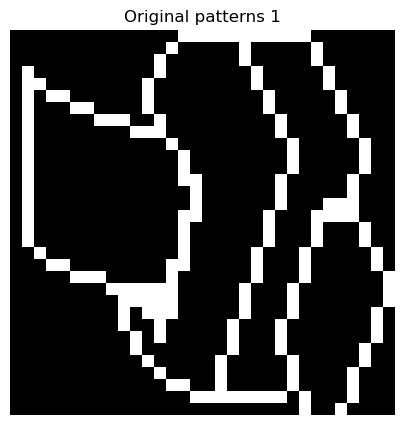

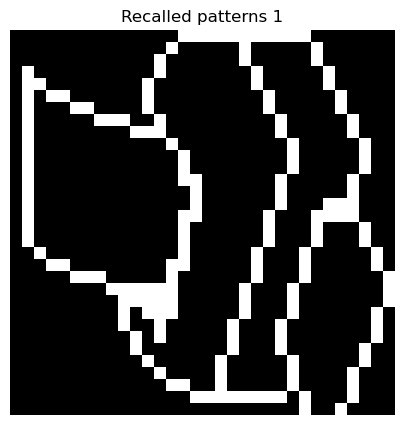

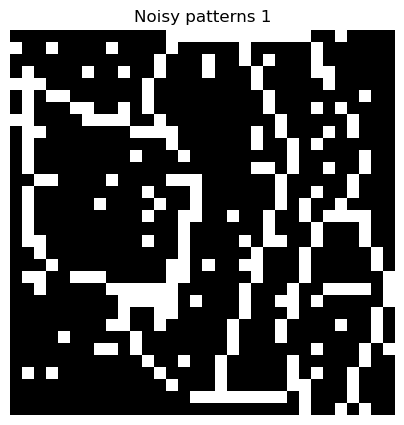

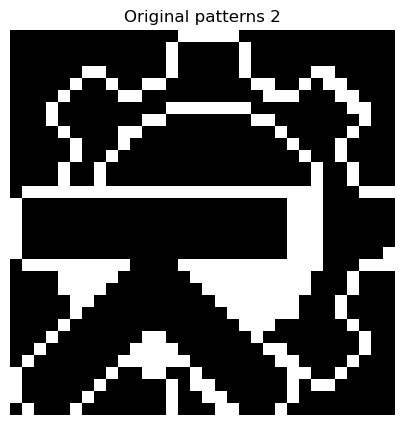

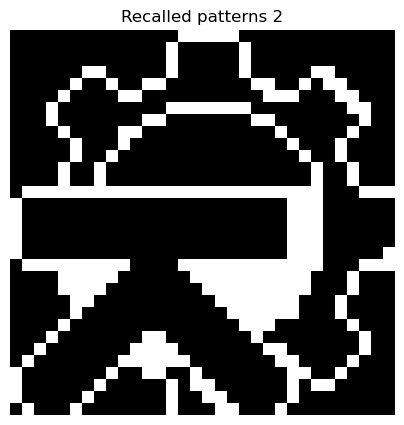

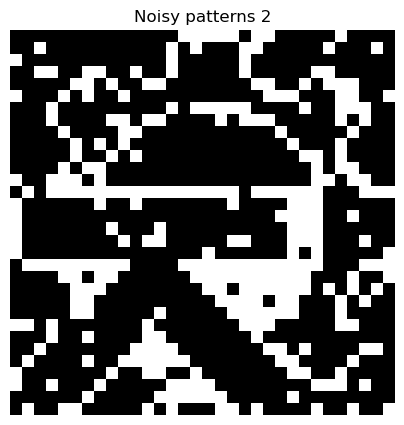

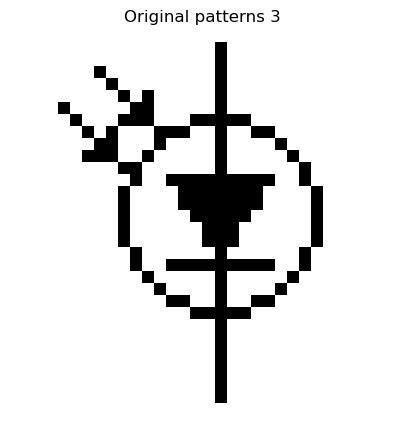

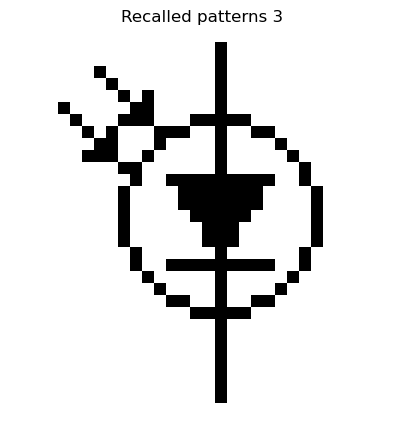

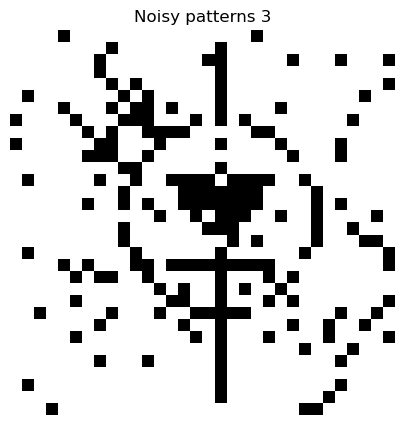

In [11]:
# MARK: -3.2.1 Check that the three patterns are stable.
train_patterns = patterns[:3].copy()

hopfield = Hopfield(1024)
hopfield.train(train_patterns)

# Add noise to the first 3 patterns and recall them
noise1 = train_patterns[0].copy()
noise2 = train_patterns[1].copy()
noise3 = train_patterns[2].copy()

# Change the sign of 100 random pixels
for i in range(100):
    noise1[np.random.randint(0, 1024)] *= -1
    noise2[np.random.randint(0, 1024)] *= -1
    noise3[np.random.randint(0, 1024)] *= -1

noisy_patterns = np.array([noise1, noise2, noise3])

# Recall the patterns
recall1 = hopfield.recall(noise1)
recall2 = hopfield.recall(noise2)
recall3 = hopfield.recall(noise3)

recalled_patterns = np.array([recall1, recall2, recall3])

for i in range(len(train_patterns)):
    display_patterns(train_patterns[i], title=f'Original patterns {i+1}')
    display_patterns(recalled_patterns[i], title=f'Recalled patterns {i+1}')
    display_patterns(noisy_patterns[i], title=f'Noisy patterns {i+1}')
    


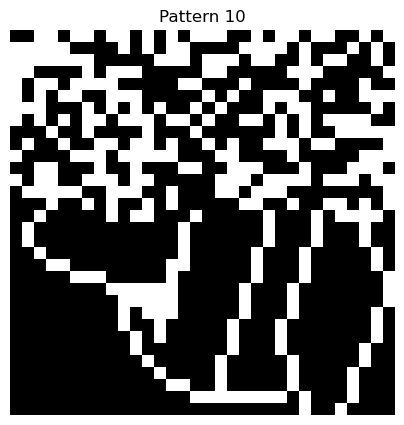

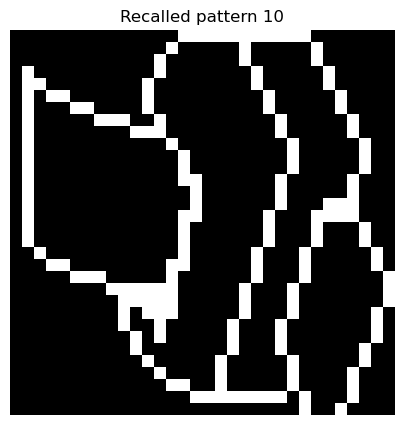

In [12]:
# MARK: -3.2.2 Can the network complete a degraded pattern? Try the pattern p10, which is a degraded version of p1, or p11 which is a mixture of p2 and p3.
p10 = patterns[-2].copy()
p11 = patterns[-1].copy()

# Recall the patterns
recall10 = hopfield.recall(p10)
recall11 = hopfield.recall(p11)

display_patterns(p10, title='Pattern 10')
display_patterns(recall10, title='Recalled pattern 10')


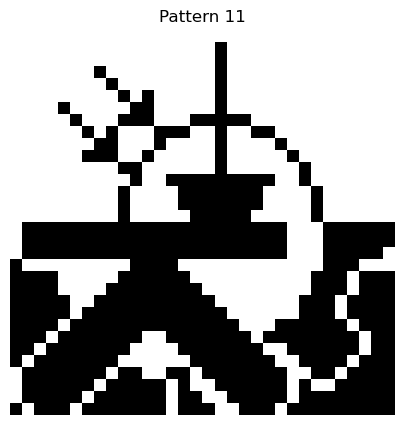

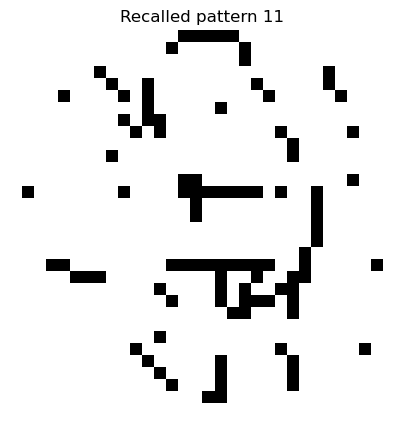

In [13]:
display_patterns(p11, title='Pattern 11')
display_patterns(recall11, title='Recalled pattern 11')


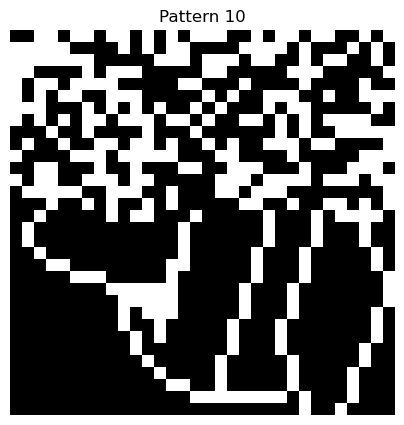

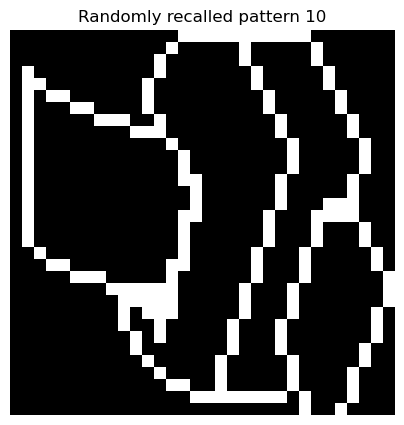

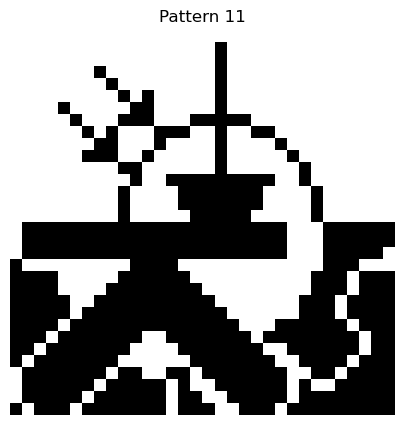

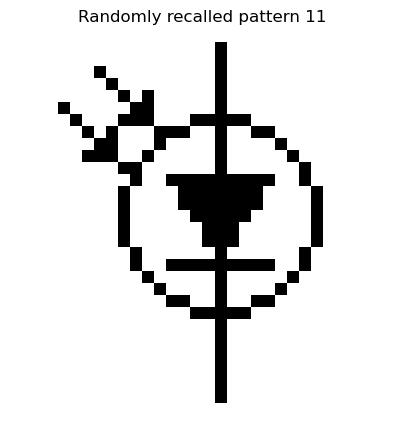

In [14]:
# MARK: -3.2.3 Clearly convergence is practically instantaneous. What happens if we select units randomly? 
# Please calculate their new state and then repeat the process in the spirit of the original sequential Hopfield dynamics. 
# Please demonstrate the image every hundredth iteration or so.
p10_random_recall, p10_states = hopfield.recall(p10, update_mode='asynchronous', save_states=True)
p11_random, p11_states = hopfield.recall(p11, update_mode='asynchronous', save_states=True)

display_patterns(p10, title='Pattern 10')
display_patterns(p10_random_recall, title='Randomly recalled pattern 10')
display_patterns(p11, title='Pattern 11')
display_patterns(p11_random, title='Randomly recalled pattern 11')

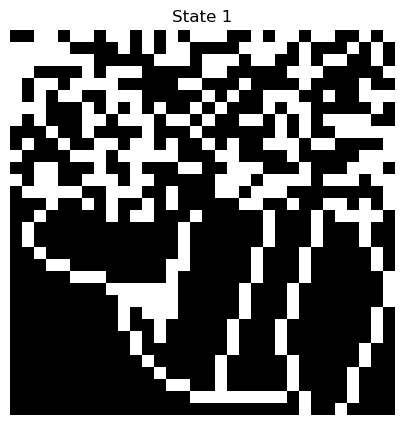

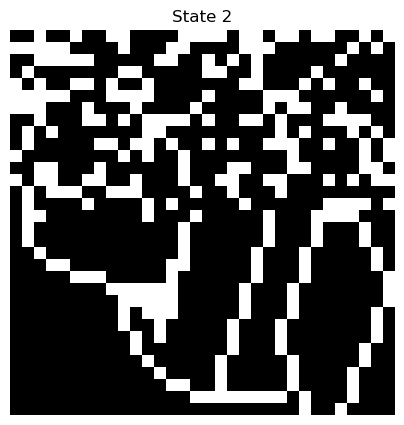

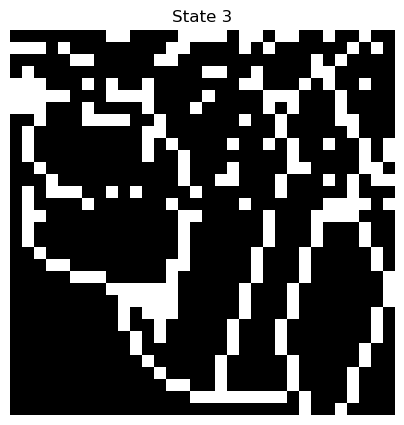

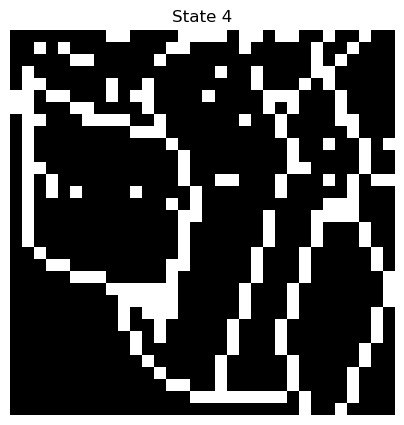

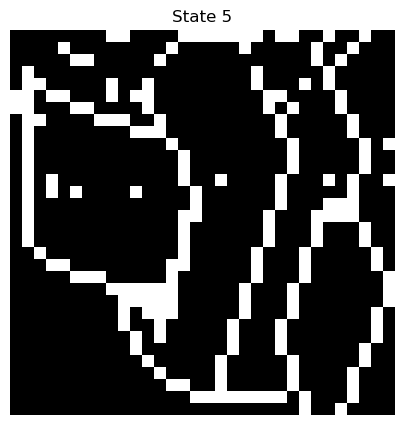

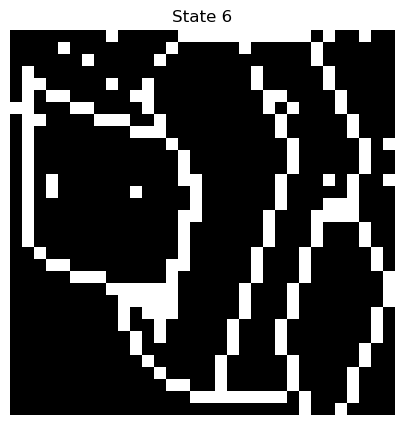

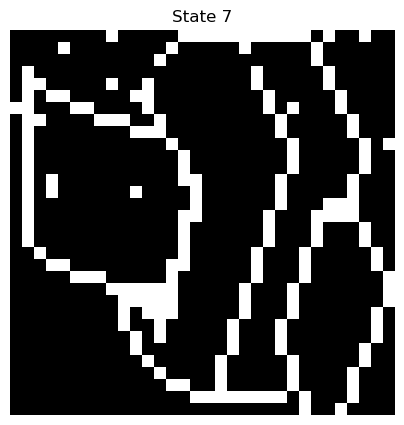

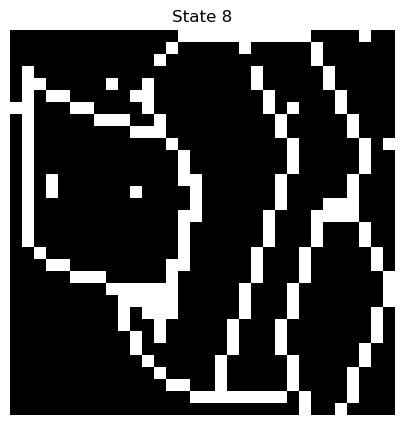

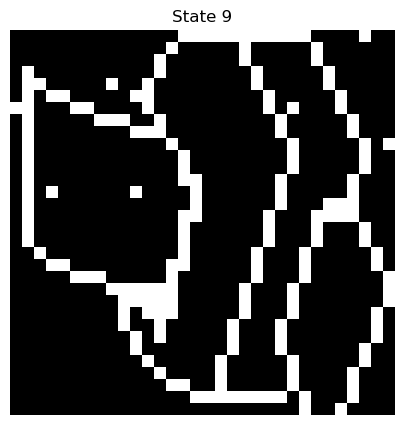

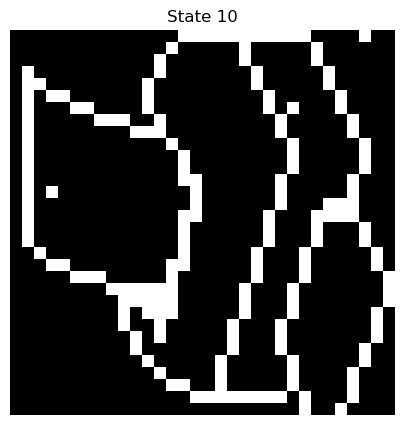

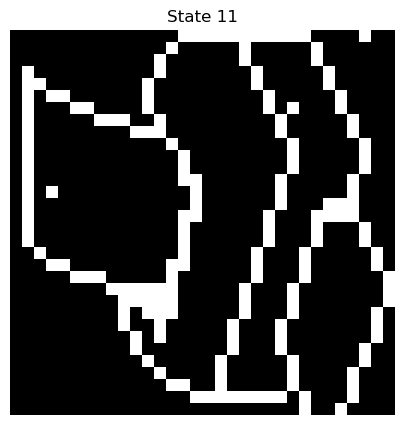

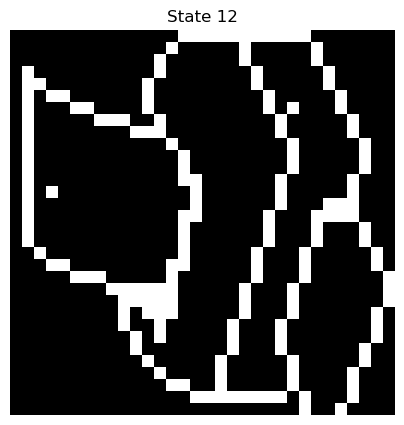

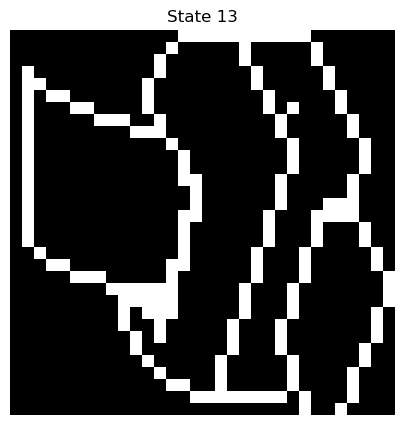

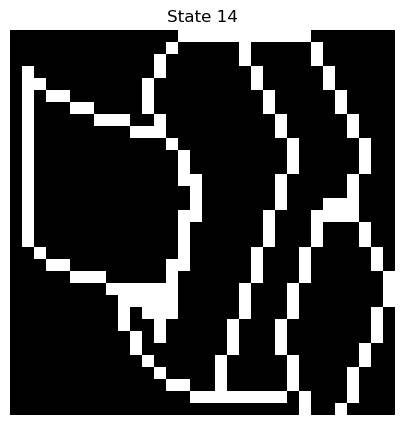

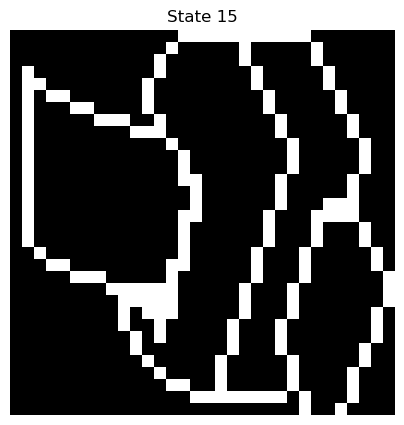

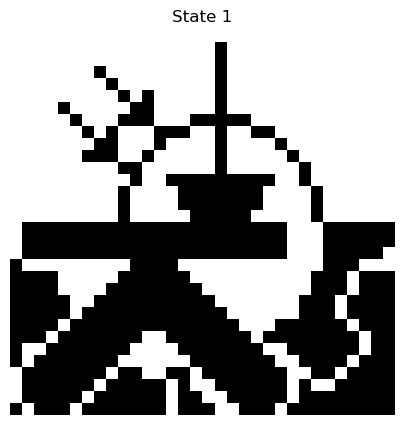

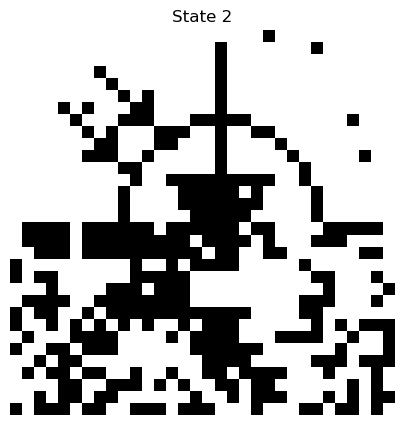

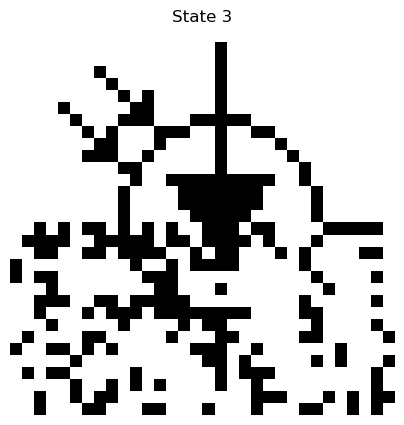

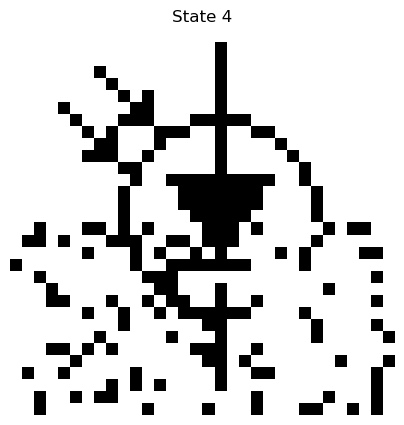

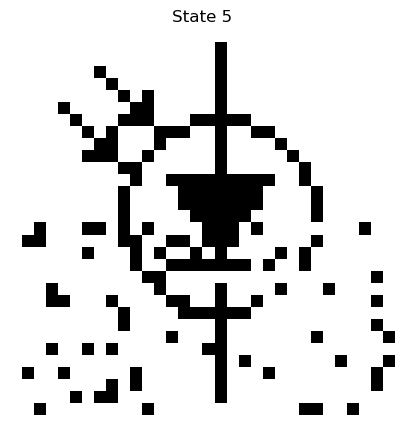

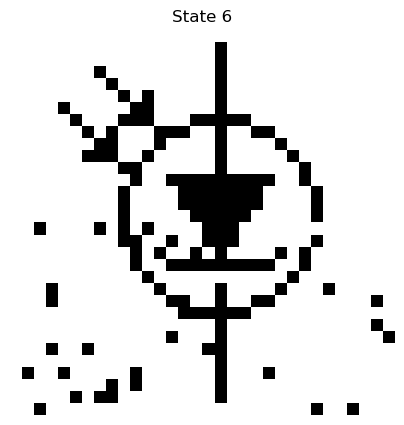

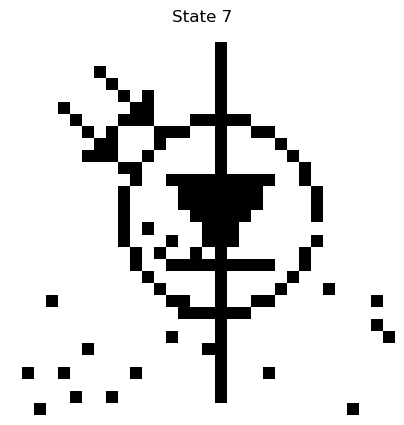

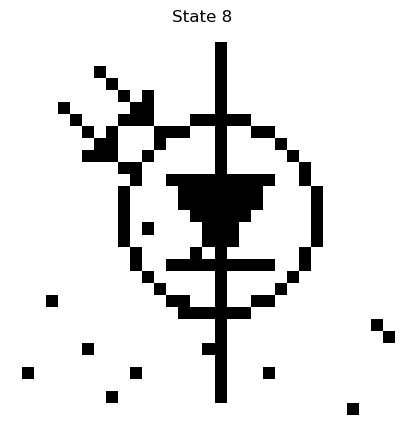

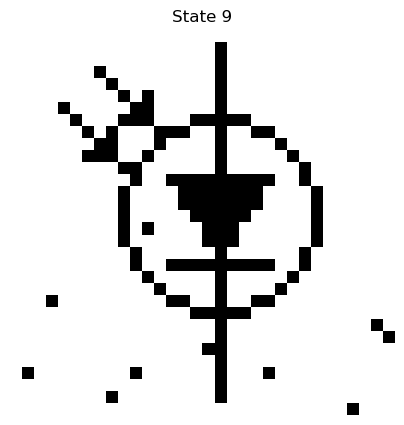

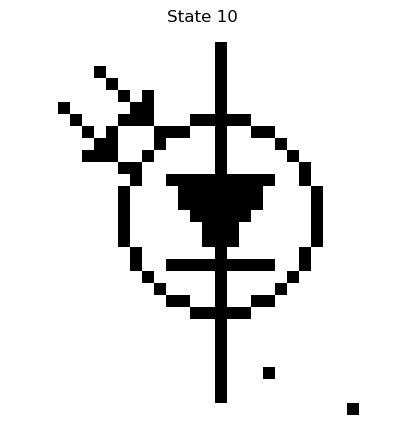

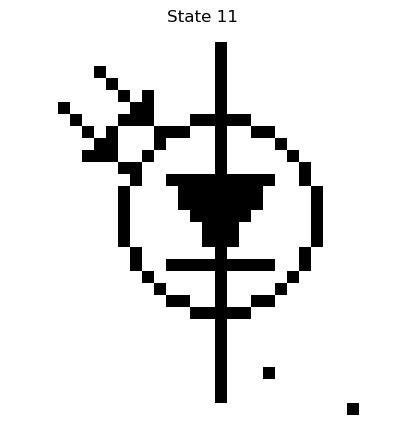

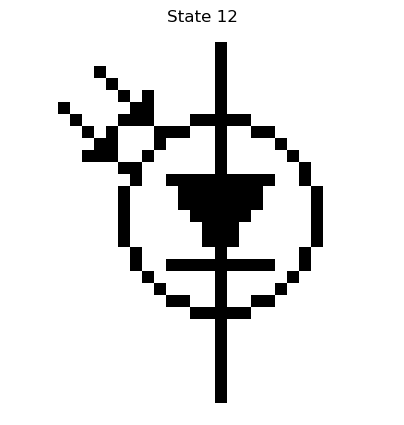

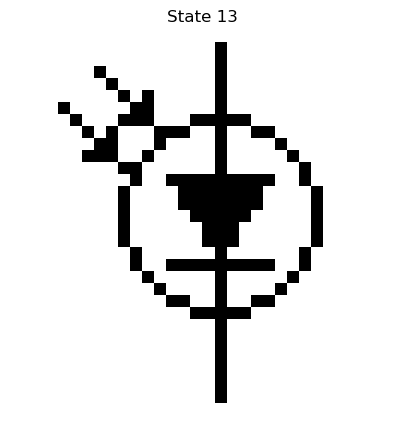

In [15]:
# Display the states of the network during the recall process
for i in range(len(p10_states)):
    display_patterns(p10_states[i], title=f'State {i+1}')

for i in range(len(p11_states)):
    display_patterns(p11_states[i], title=f'State {i+1}')

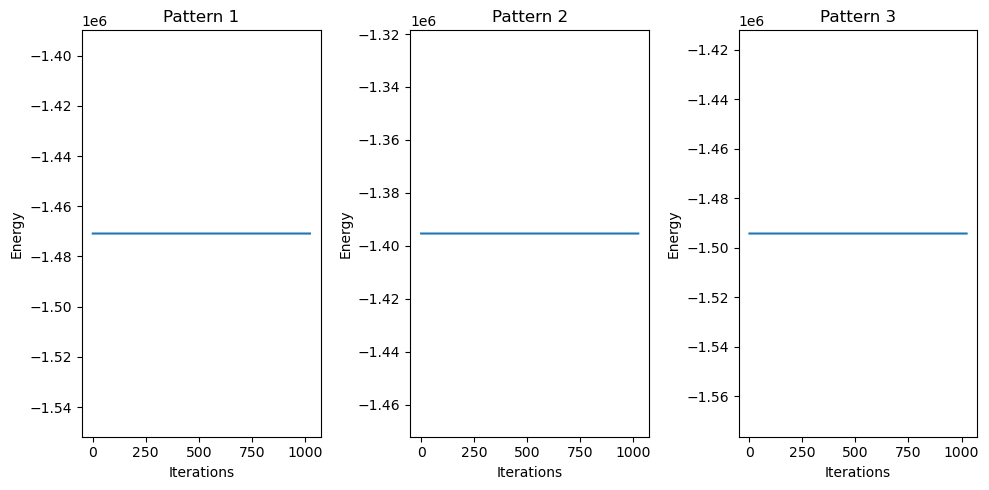

In [16]:
# MARK: -3.3
# MARK: -3.3.1 What is the energy at the diferent attractors?

hopfield = Hopfield(1024)
hopfield.train(train_patterns)

p1_energy, p1_energy_list = hopfield.recall(train_patterns[0], update_mode='asynchronous', return_energy=True)
p2_energy, p2_energy_list = hopfield.recall(train_patterns[1], update_mode='asynchronous', return_energy=True)
p3_energy, p3_energy_list = hopfield.recall(train_patterns[2], update_mode='asynchronous', return_energy=True)

# Plot the energy of the network during the recall process
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(p1_energy_list if i == 0 else p2_energy_list if i == 1 else p3_energy_list)
    plt.title(f'Pattern {i+1}')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
plt.tight_layout()
plt.show()


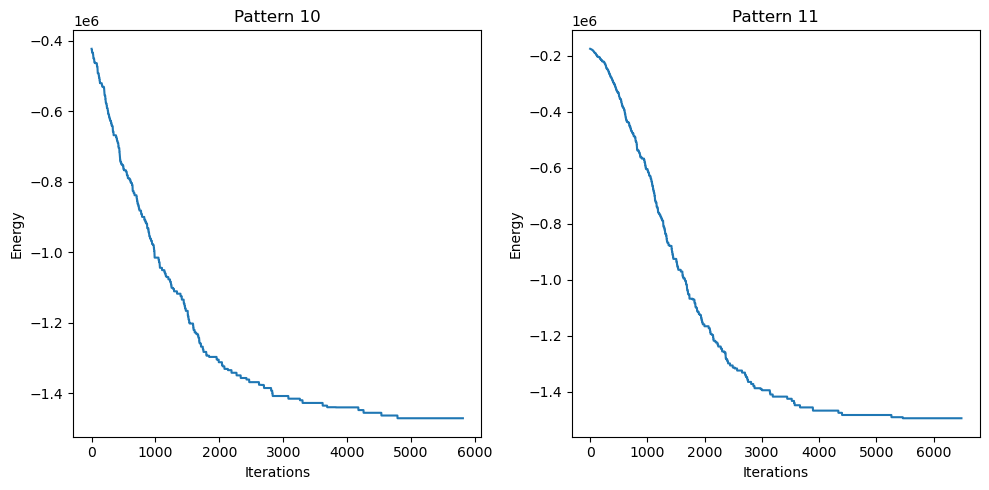

In [17]:
# MARK: -3.3.2/3 What is the energy at the points of the distorted patterns?
# Follow how the energy changes from iteration to iteration when you use the sequential update rule to approach an attractor.
p10 = patterns[-2].copy()
p11 = patterns[-1].copy()

p10_energy, p10_energy_list = hopfield.recall(p10, update_mode='asynchronous', return_energy=True)
p11_energy, p11_energy_list = hopfield.recall(p11, update_mode='asynchronous', return_energy=True)


# Plot the energy of the network during the recall process
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(p10_energy_list if i == 0 else p11_energy_list)
    plt.title(f'Pattern {i+10}')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
plt.tight_layout()
plt.show()


Max asymmetry in symmetric case: 0.0


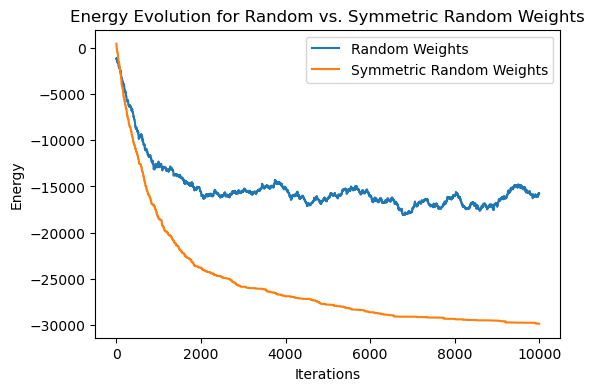

In [18]:
# MARK: -3.3.3/4 Generate a weight matrix by setting the weights to normally distributed random numbers, and try iterating an arbitrary starting state.
# What happens?
# Make the weight matrix symmetric (e.g. by setting w=0.5*(w+w')). What happens now? Why?

# Train the network with random weights
hopfield = Hopfield(1024)
hopfield.train(train_patterns, random_weights=True)

# Train the network as normal
hopfield2 = Hopfield(1024)
hopfield2.train(train_patterns, random_weights=True, symmetric_weights=True)


# Generate a random starting state and recall it
random_state = np.random.choice([-1, 1], size=1024)

# Recall the random pattern
random_recall, random_energy = hopfield.recall(random_state, update_mode='asynchronous', return_energy=True)
sym_recall, sym_energy = hopfield2.recall(random_state, update_mode='asynchronous', return_energy=True)


# display_patterns(random_state, title='Random state')
# display_patterns(random_recall, title='Recalled random state using random weights')
# display_patterns(normal_recall, title='Recalled random state using normal weights')
# display_patterns(recall, title='Recalled random state using symmetric weights')

# Plot the energy of the network during the recall process
plt.figure(figsize=(6, 4))
plt.plot(random_energy, label='Random Weights')
plt.plot(sym_energy, label='Symmetric Random Weights')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.title('Energy Evolution for Random vs. Symmetric Random Weights')
plt.show()




Noise Level: 0.0% - Number of flips: 0
Noise Level: 10.0% - Number of flips: 102
Noise Level: 20.0% - Number of flips: 204
Noise Level: 30.0% - Number of flips: 307
Noise Level: 40.0% - Number of flips: 409
Noise Level: 50.0% - Number of flips: 512
Noise Level: 60.0% - Number of flips: 614
Noise Level: 70.0% - Number of flips: 716
Noise Level: 80.0% - Number of flips: 819
Noise Level: 90.0% - Number of flips: 921
Noise Level: 100.0% - Number of flips: 1024


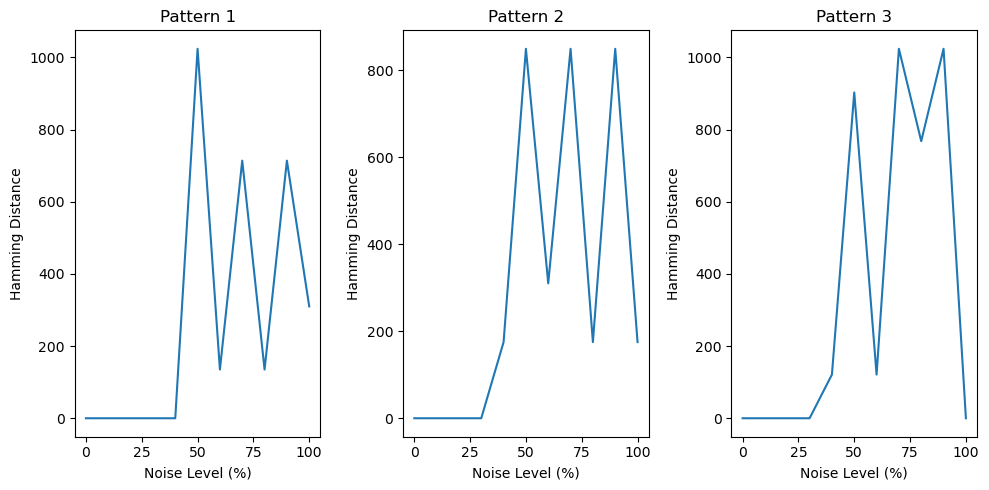

In [19]:
# MARK: -3.4 

hopfield = Hopfield(1024)
hopfield.train(train_patterns)

# Generate levels of noise from 0 to 100% for the input patterns
noise_patterns = train_patterns.copy()
noise_levels = np.linspace(0, 100, 11)

# Recall the patterns with different noise levels
recalled_patterns = {'pattern1': {'noise': [], 'recall': [], 'hamming': []}, 
                     'pattern2': {'noise': [], 'recall': [], 'hamming': []},
                     'pattern3': {'noise': [], 'recall': [], 'hamming': []}
                     }

for noise_lvl in noise_levels:
    # Generate random indices to flip (without replacement)
    num_flips = int(1024 * noise_lvl / 100)
    print(f'Noise Level: {noise_lvl}% - Number of flips: {num_flips}')
    
    # Generate unique flip indices for each pattern
    flip_indices_1 = np.random.choice(1024, num_flips, replace=False)
    flip_indices_2 = np.random.choice(1024, num_flips, replace=False)
    flip_indices_3 = np.random.choice(1024, num_flips, replace=False)
    
    # Apply the flips
    noise_patterns[0][flip_indices_1] *= -1
    noise_patterns[1][flip_indices_2] *= -1
    noise_patterns[2][flip_indices_3] *= -1
    
    # Recall the noisy patterns
    recall1 = hopfield.recall(noise_patterns[0])
    recall2 = hopfield.recall(noise_patterns[1])
    recall3 = hopfield.recall(noise_patterns[2])

    # Calculate the hamming distance
    hamming1 = np.sum(train_patterns[0] != recall1)
    hamming2 = np.sum(train_patterns[1] != recall2)
    hamming3 = np.sum(train_patterns[2] != recall3)

    # Store the results
    recalled_patterns['pattern1']['noise'].append(noise_lvl)
    recalled_patterns['pattern2']['noise'].append(noise_lvl)
    recalled_patterns['pattern3']['noise'].append(noise_lvl)
    recalled_patterns['pattern1']['recall'].append(recall1)
    recalled_patterns['pattern2']['recall'].append(recall2)
    recalled_patterns['pattern3']['recall'].append(recall3)
    recalled_patterns['pattern1']['hamming'].append(hamming1)
    recalled_patterns['pattern2']['hamming'].append(hamming2)
    recalled_patterns['pattern3']['hamming'].append(hamming3)

# Plot the results
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(recalled_patterns[f'pattern{i+1}']['noise'], recalled_patterns[f'pattern{i+1}']['hamming'])
    plt.title(f'Pattern {i+1}')
    plt.xlabel('Noise Level (%)')
    plt.ylabel('Hamming Distance')
plt.tight_layout()
plt.show()

Number of stored patterns: 3


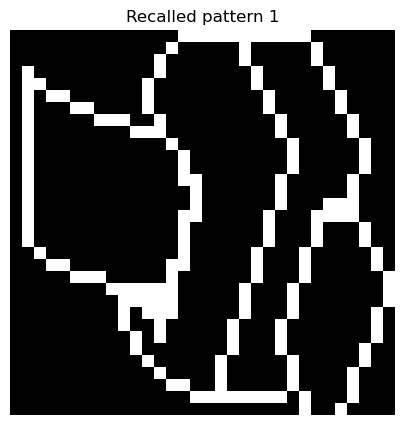

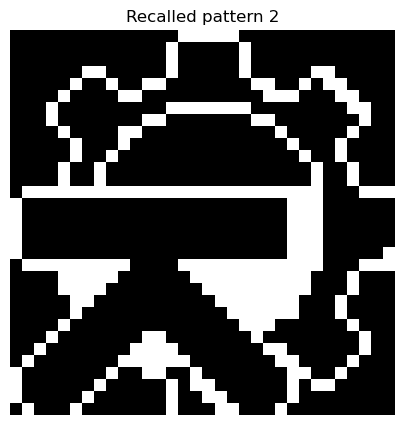

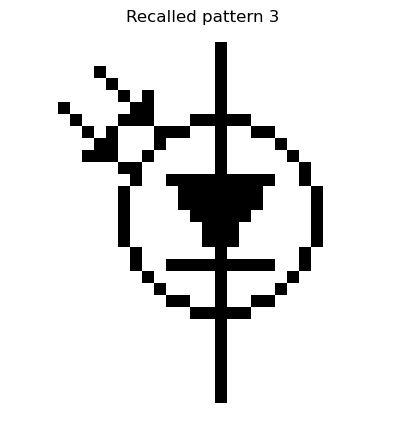

Number of stored patterns: 4


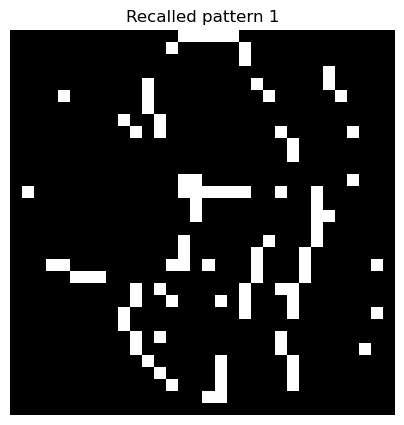

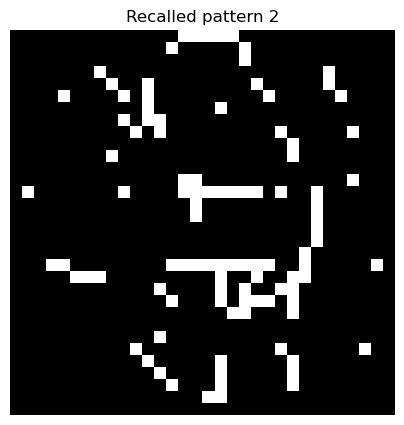

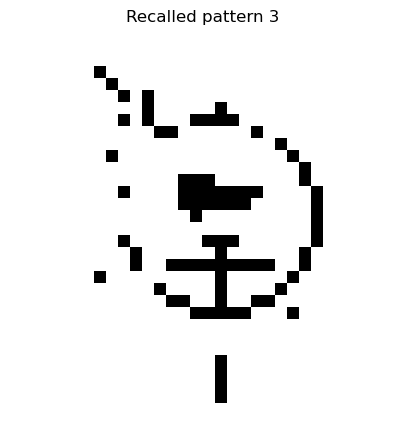

Number of stored patterns: 5


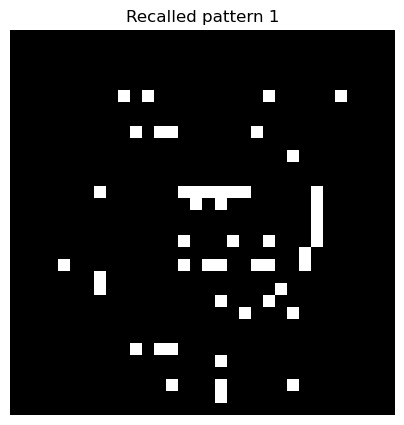

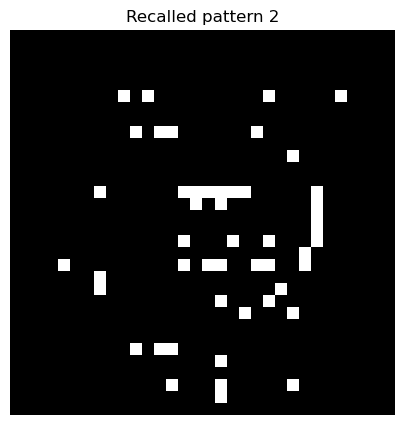

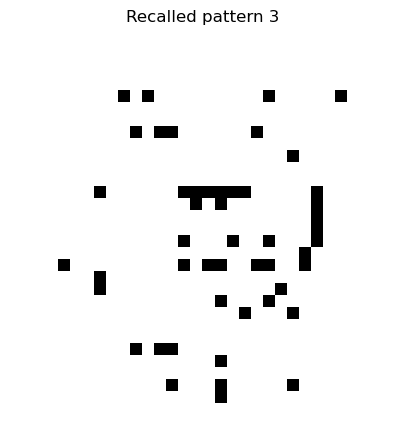

Number of stored patterns: 6


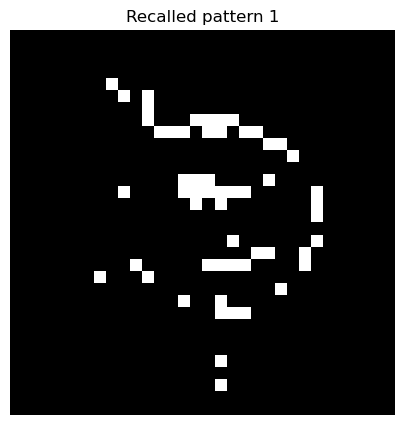

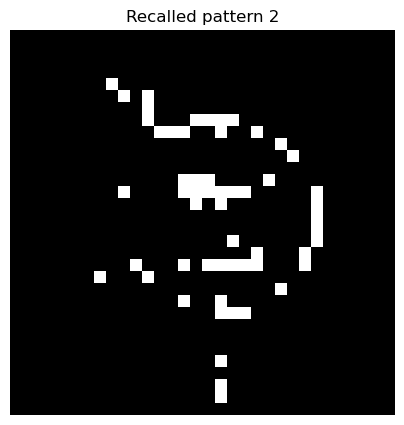

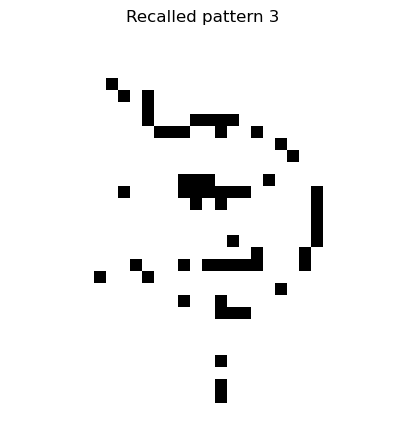

Number of stored patterns: 7


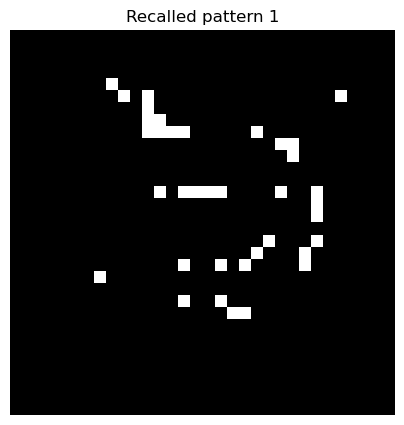

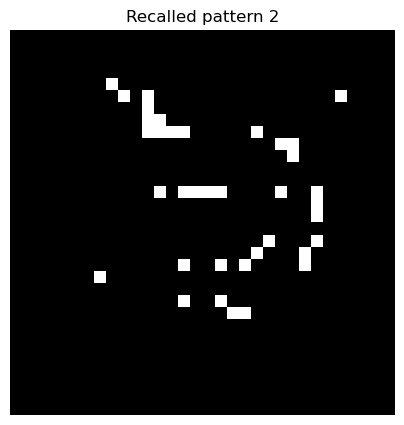

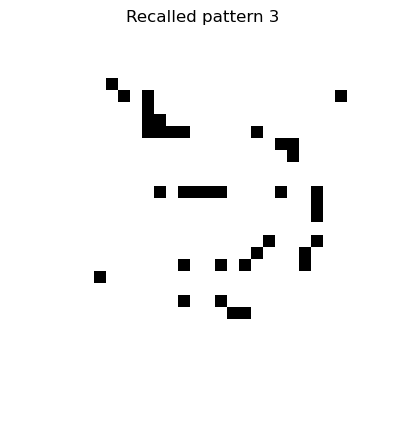

In [20]:
# MARK: -3.5 How many patterns could safely be stored? Was the drop in performance gradual or abrupt?

# Slightly distort each pattern
p1_distorted = patterns[0].copy()
p2_distorted = patterns[1].copy()
p3_distorted = patterns[2].copy()
p4_distorted = patterns[3].copy()
p5_distorted = patterns[4].copy()
p6_distorted = patterns[5].copy()
p7_distorted = patterns[6].copy()
p8_distorted = patterns[7].copy()
p9_distorted = patterns[8].copy()

# Change the sign of 100 random pixels
flip_indices_1 = np.random.choice(1024, 100, replace=False)

p1_distorted[flip_indices_1] *= -1
p2_distorted[flip_indices_1] *= -1
p3_distorted[flip_indices_1] *= -1
p4_distorted[flip_indices_1] *= -1
p5_distorted[flip_indices_1] *= -1
p6_distorted[flip_indices_1] *= -1
p7_distorted[flip_indices_1] *= -1
p8_distorted[flip_indices_1] *= -1
p9_distorted[flip_indices_1] *= -1

# Train the network with first 4 patterns, then add the rest one by one and check the recall
for i in range(3, 8):
    hopfield = Hopfield(1024)
    train_patterns = patterns[:i].copy()
    hopfield.train(train_patterns)

    # Recall the first 3 patterns
    recall1 = hopfield.recall(p1_distorted)
    recall2 = hopfield.recall(p2_distorted)
    recall3 = hopfield.recall(p3_distorted)

    # Calculate the hamming distance
    hamming1 = np.sum(patterns[0] != recall1)
    hamming2 = np.sum(patterns[1] != recall2)
    hamming3 = np.sum(patterns[2] != recall3)

    print(f'Number of stored patterns: {i}')

    display_patterns(recall1, title='Recalled pattern 1')
    display_patterns(recall2, title='Recalled pattern 2')
    display_patterns(recall3, title='Recalled pattern 3')




In [21]:
num_patterns = 300
num_units = 100
# hopfield = Hopfield(num_units)
# hopfield_sc = Hopfield(num_units)

# Generate 300 random patterns of size 100
random_patterns = np.random.randint(0, 2, size=(num_patterns, num_units)) * 2 - 1

# Track stability
stable_counts = np.zeros(num_patterns, dtype=int)
stable_counts_sc = np.zeros(num_patterns, dtype=int)
stable_percentage = np.zeros(num_patterns)
stable_percentage_sc = np.zeros(num_patterns)

# Train the network incrementally
for i in range(1, num_patterns + 1):  # Start from 1 to avoid empty slice
    # Train on all patterns seen so far (incremental training)
    hopfield = Hopfield(num_units)
    hopfield_sc = Hopfield(num_units)
    hopfield.train(random_patterns[:i], self_connect=False)
    hopfield_sc.train(random_patterns[:i], self_connect=True)

    # **Optimized Stability Check**
    stable_counts[i - 1] = np.sum([hopfield.is_stable(random_patterns[j]) for j in range(i)])
    stable_counts_sc[i - 1] = np.sum([hopfield_sc.is_stable(random_patterns[j]) for j in range(i)])

    # **Fix Stability Percentage Calculation**
    stable_percentage[i - 1] = (stable_counts[i - 1] / i) * 100
    stable_percentage_sc[i - 1] = (stable_counts_sc[i - 1] / i) * 100


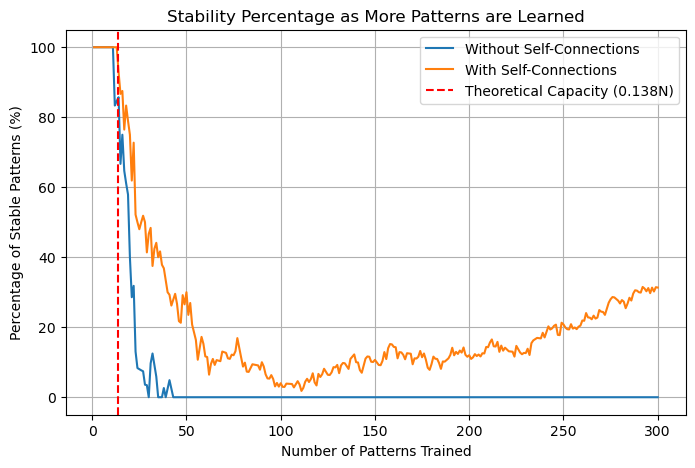

In [22]:
# Create the plot
plt.figure(figsize=(8, 5))

# Plot stable percentage over training iterations
plt.plot(range(1, num_patterns + 1), stable_percentage, label="Without Self-Connections", linestyle="-")
plt.plot(range(1, num_patterns + 1), stable_percentage_sc, label="With Self-Connections", linestyle="-")

# Add a vertical line at the theoretical capacity of the network num_units*0.138
plt.axvline(x=num_units * 0.138, color='r', linestyle='--', label='Theoretical Capacity (0.138N)')

# Labels and title
plt.xlabel("Number of Patterns Trained")
plt.ylabel("Percentage of Stable Patterns (%)")
plt.title("Stability Percentage as More Patterns are Learned")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [23]:
num_patterns = 300
num_units = 100
# hopfield = Hopfield(num_units)
# hopfield_sc = Hopfield(num_units)

# Generate 300 random patterns of size 100
random_patterns = np.sign(0.5 + np.random.randn(num_patterns, num_units))

# Track stability
stable_counts = np.zeros(num_patterns, dtype=int)
stable_counts_sc = np.zeros(num_patterns, dtype=int)
stable_percentage = np.zeros(num_patterns)
stable_percentage_sc = np.zeros(num_patterns)

# Train the network incrementally
for i in range(1, num_patterns + 1):  # Start from 1 to avoid empty slice
    # Train on all patterns seen so far (incremental training)
    hopfield = Hopfield(num_units)
    hopfield_sc = Hopfield(num_units)
    hopfield.train(random_patterns[:i], self_connect=False)
    hopfield_sc.train(random_patterns[:i], self_connect=True)

    # **Optimized Stability Check**
    stable_counts[i - 1] = np.sum([hopfield.is_stable(random_patterns[j]) for j in range(i)])
    stable_counts_sc[i - 1] = np.sum([hopfield_sc.is_stable(random_patterns[j]) for j in range(i)])

    # **Fix Stability Percentage Calculation**
    stable_percentage[i - 1] = (stable_counts[i - 1] / i) * 100
    stable_percentage_sc[i - 1] = (stable_counts_sc[i - 1] / i) * 100


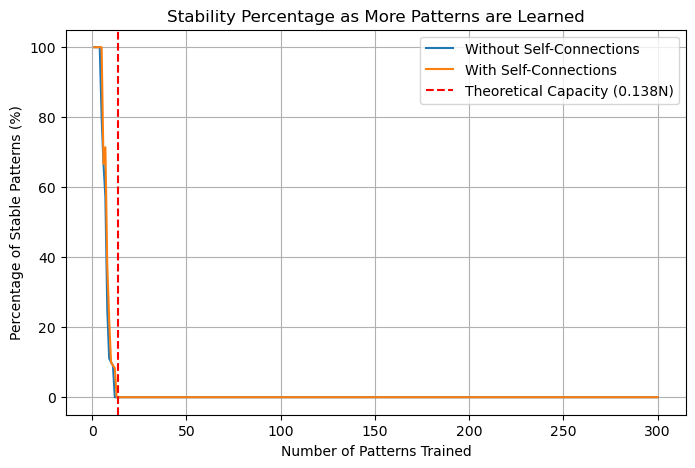

In [24]:
# Create the plot
plt.figure(figsize=(8, 5))

# Plot stable percentage over training iterations
plt.plot(range(1, num_patterns + 1), stable_percentage, label="Without Self-Connections", linestyle="-")
plt.plot(range(1, num_patterns + 1), stable_percentage_sc, label="With Self-Connections", linestyle="-")

# Add a vertical line at the theoretical capacity of the network num_units*0.138
plt.axvline(x=num_units * 0.138, color='r', linestyle='--', label='Theoretical Capacity (0.138N)')

# Labels and title
plt.xlabel("Number of Patterns Trained")
plt.ylabel("Percentage of Stable Patterns (%)")
plt.title("Stability Percentage as More Patterns are Learned")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [25]:
def generate_sparse_patterns(N, P, rho):
    patterns = []
    for _ in range(P):
        pattern = np.zeros(N)
        num_ones = int(np.round(rho * N))
        ones_idx = np.random.choice(N, num_ones, replace=False)
        pattern[ones_idx] = 1
        patterns.append(pattern)
    return np.array(patterns)

In [26]:
def recall_success_rate(N, P, rho, theta, num_trials=5):
    """Train and test the recall success rate for a given (N, P, rho, theta)."""
    successes = 0
    for _ in range(num_trials):
        patterns = generate_sparse_patterns(N, P, rho)
        hopfield = Hopfield(N)
        hopfield.train(patterns, self_connect=True, sparsity=True)

        # Test recall success: count how many patterns are recalled correctly
        recalled_correctly = sum(
            hopfield.is_stable(pattern, theta=theta, sparsity=True) for pattern in patterns
        )

        success_rate = recalled_correctly / P  # Fraction of correctly recalled patterns
        successes += success_rate

    return successes / num_trials  # Average over trials



rho: 0.1, P: 5, success rates: [0.0, 0.06000000000000001, 0.32, 0.6599999999999999, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
rho: 0.1, P: 10, success rates: [0.0, 0.0, 0.04, 0.27999999999999997, 0.37, 0.8400000000000001, 0.9100000000000001, 1.0, 0.9800000000000001, 1.0, 0.0]
rho: 0.1, P: 20, success rates: [0.0, 0.0, 0.0, 0.005, 0.034999999999999996, 0.155, 0.485, 0.7, 0.805, 0.9600000000000002, 0.215]
rho: 0.1, P: 30, success rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.006666666666666666, 0.056666666666666664, 0.2233333333333333, 0.43, 0.6799999999999999, 0.4133333333333334]
rho: 0.1, P: 40, success rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024999999999999998, 0.1125, 0.35, 0.29]
rho: 0.1, P: 50, success rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.01, 0.039999999999999994, 0.154]
rho: 0.1, P: 60, success rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006666666666666666, 0.03833333333333333]
rho: 0.05, P: 5, success rates: [0.3, 0.9, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
rh

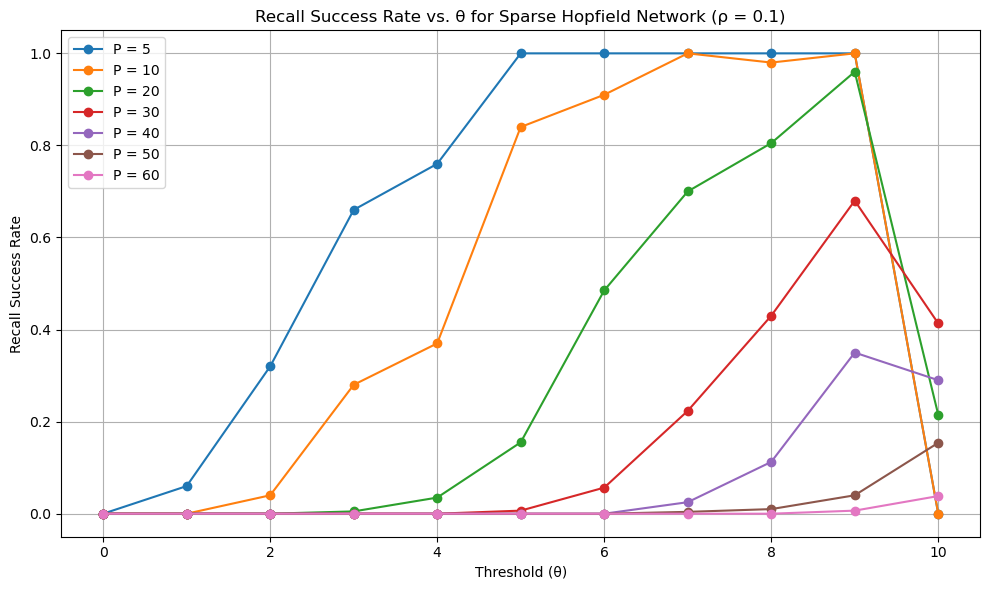

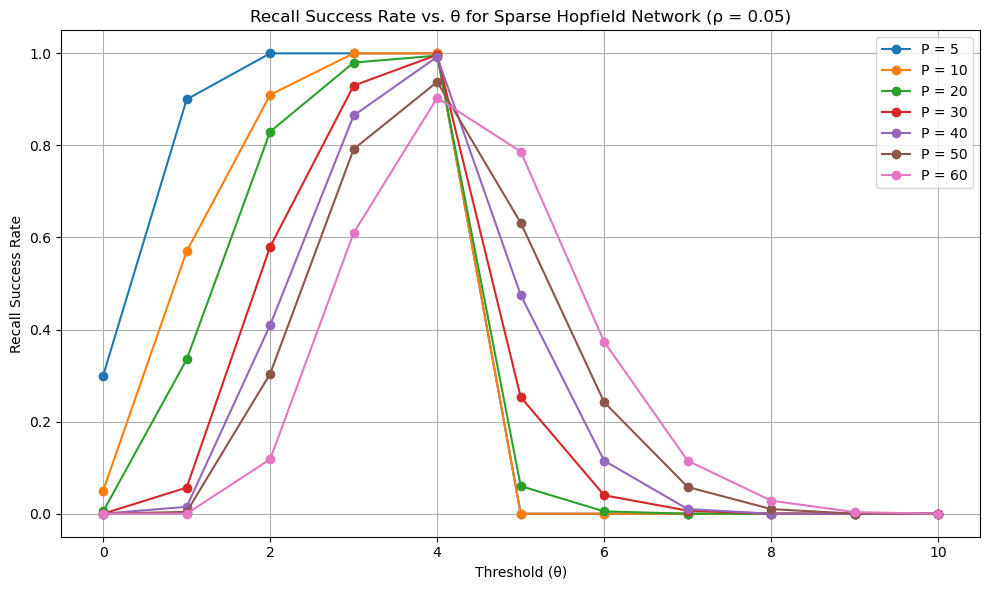

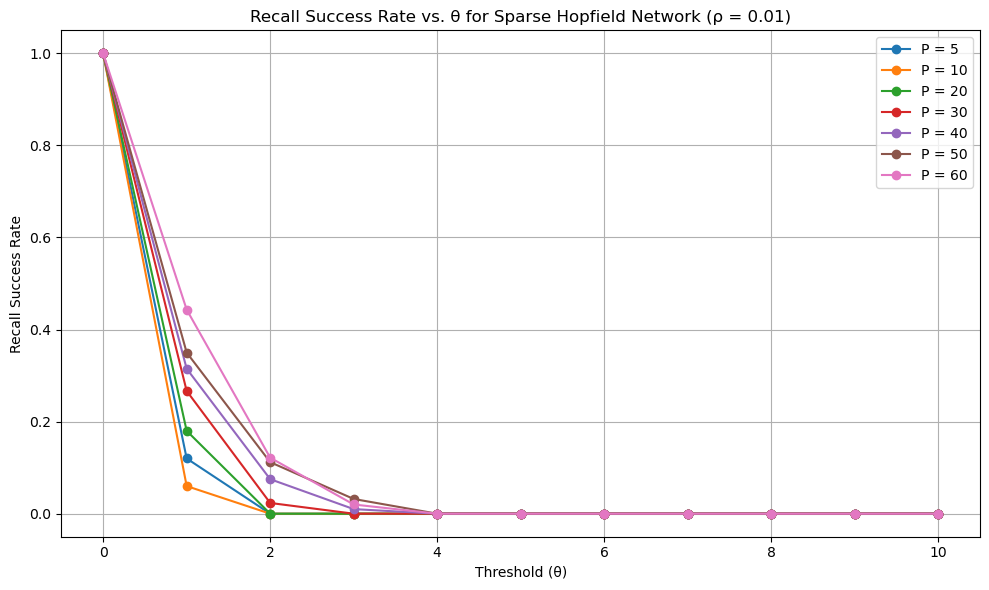

In [27]:
# Parameters
N = 100                 # Number of neurons
Ps = [5, 10, 20, 30, 40, 50, 60]  # Different numbers of stored patterns
rhos = [0.1, 0.05, 0.01]  # Different sparsity levels
thetas = np.linspace(0, 10, 11)  # Range of theta values
num_trials = 10  # Trials per experiment

# Store results: {rho -> {P -> [success rates for each theta]}}
results = {rho: {P: [] for P in Ps} for rho in rhos}

# Run experiments
for rho in rhos:
    for P in Ps:
        for theta in thetas:
            success_rate = recall_success_rate(N, P, rho, theta, num_trials)
            results[rho][P].append(success_rate)  # Store success rate
        print(f"rho: {rho}, P: {P}, success rates: {results[rho][P]}")

# Plot results: 3 separate plots, one per rho
for rho in rhos:
    plt.figure(figsize=(10, 6))
    for P in Ps:
        plt.plot(thetas, results[rho][P], marker='o', linestyle='-', label=f"P = {P}")
    plt.xlabel("Threshold (θ)")
    plt.ylabel("Recall Success Rate")
    plt.title(f"Recall Success Rate vs. θ for Sparse Hopfield Network (ρ = {rho})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
